# State frequency analysis 

/var/folders/6q/3gs9cqgs6ll9y2vljypxl7n80000gn/T/ipykernel_46224/3725249996.py:105: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pars = pd.read_csv(os.path.join(pt,"TS_parameters.dat"),


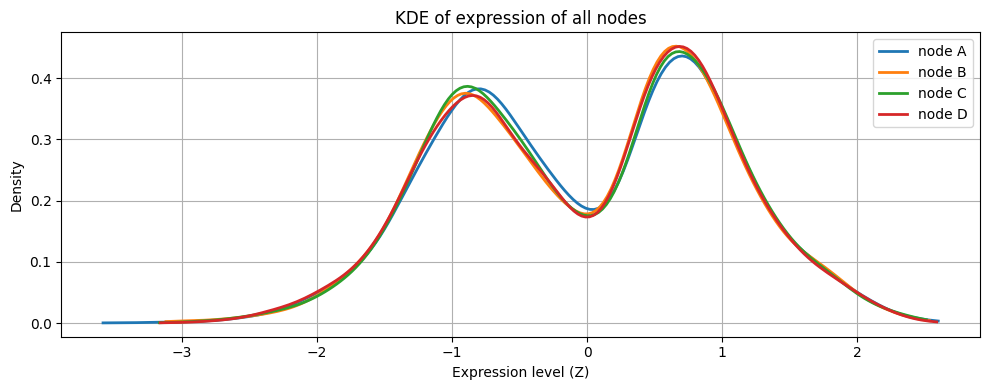

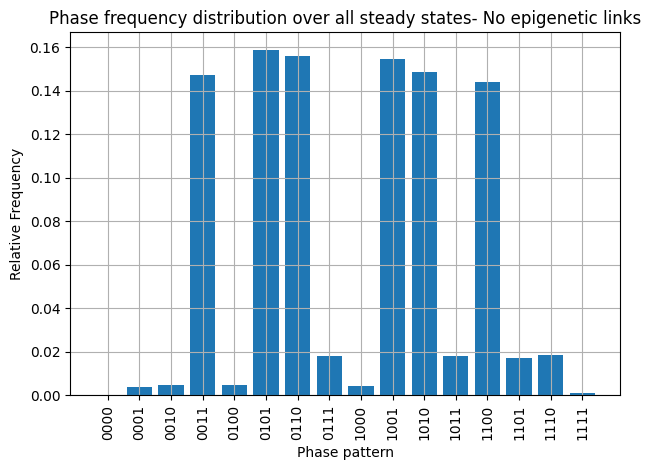

In [92]:
import os
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from collections import Counter

# ——————————————————————————————————————————————————————————————————————————————
# Functions mirroring the MATLAB script
# ——————————————————————————————————————————————————————————————————————————————

def Z_normalizing(df):
    dfn = df.copy().astype(float)
    means = dfn.iloc[:,2:].mean(axis=0)
    stds  = dfn.iloc[:,2:].std(axis=0)
    dfn.iloc[:,2:] = (dfn.iloc[:,2:] - means) / stds
    return dfn

def state_count(dfb):
    counts = dfb.groupby([0,1]).size()
    freq   = counts.value_counts().sort_index()
    M      = counts.max()
    return [int(freq.get(i,0)) for i in range(1, M+1)]

def phase_changer(df, thresholds):
    dfb = df.copy().astype(float)
    n_thr = len(thresholds)
    for col in range(2, dfb.shape[1]):
        th = thresholds[(col-2) % n_thr]
        dfb.iloc[:,col] = (dfb.iloc[:,col] > th).astype(int)
    return dfb

def phase_counter(dfb):
    pats = dfb.iloc[:,2:].astype(int).astype(str).agg(''.join, axis=1)
    freq = pats.value_counts()
    return freq.index.tolist(), freq.values.tolist()

def state_divider(dfb):
    # cast states to int so keys are ints
    dfb.iloc[:,1] = dfb.iloc[:,1].astype(int)
    return {s: dfb[dfb.iloc[:,1] == s]
            for s in sorted(dfb.iloc[:,1].unique())}


def phase_counting_and_arrangement_for_all_states(divided, n_nodes=4):
    """
    For each multistability case:
      • for each parameter set (grouped by column 0), take its ns rows
        of boolean data (columns 2…2+n_nodes), flatten into a single
        vector of length ns*n_nodes, and record that pattern.
      • count frequencies of these patterns across all parameter sets.
    """
    ia = {}
    phase_order = {}
    phase_freq  = {}
    all_phases  = {}
    organized   = {}

    for ns, df_sub in divided.items():
        patterns = []
        organized_list = []
        # group by parameter index (column 0)
        for param_idx, group in df_sub.groupby(0):
            # group has exactly ns rows
            # take only the first n_nodes columns of each row
            bool_mat = group.iloc[:, 2:2 + n_nodes].to_numpy(dtype=int)
            flat = bool_mat.flatten()
            pat = ''.join(map(str, flat))
            patterns.append(pat)
            organized_list.append(flat)

        # count pattern frequencies
        freq_counter = Counter(patterns)
        freq_items = freq_counter.most_common()  # list of (pattern, count)

        # unpack into parallel lists
        pats, freqs = zip(*freq_items) if freq_items else ([], [])
        
        ia[ns]          = None
        phase_order[ns] = None
        phase_freq[ns]  = list(freqs)
        all_phases[ns]  = list(pats)
        organized[ns]   = np.vstack(organized_list) if organized_list else np.empty((0, ns*n_nodes), int)

    return ia, phase_order, phase_freq, all_phases, organized


# ——————————————————————————————————————————————————————————————————————————————
# Main analysis
# ——————————————————————————————————————————————————————————————————————————————

pt = "/Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/RACIPE-1.0/"   # update to your actual path

# 1) read variable-length solutions
data = []
with open("/Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/initial_sims/Toggle_tetrahedron/Hypothesis_test/combined_solutions2.dat") as f:
    for L in f:
        data.append([float(x) for x in L.split()])
maxlen = max(len(r) for r in data)
for r in data:
    r += [np.nan]*(maxlen-len(r))
sol = pd.DataFrame(data)

# 2) read parameters + names
pars = pd.read_csv(os.path.join(pt,"TS_parameters.dat"),
                   delim_whitespace=True, header=None)
prs_names = [ln.strip() for ln in open(os.path.join(pt,"TTr.txt")) if ln.strip()]
npars = pars.shape[1]-2
prs_names = (prs_names + [f"param{i}" for i in range(1,npars+1)])[:npars]
pars.columns = ["S_no","States_number"] + prs_names

# 3) normalize, filter, booleanize
sol_z    = Z_normalizing(sol)
sol_z    = sol_z[sol_z.iloc[:,1] < 17]
bool_sol = phase_changer(sol_z, [0,0,0,0])
# print(bool_sol.shape, bool_sol)
# ensure states_number column is int
bool_sol.iloc[:,1] = bool_sol.iloc[:,1].astype(int)

# 4) frequencies
state_freq         = state_count(bool_sol)
all_phases, all_freq = phase_counter(bool_sol)
divided            = state_divider(bool_sol)
ia, phase_order, phase_freq, phases, organized = \
    phase_counting_and_arrangement_for_all_states(divided)

# ——————————————————————————————————————————————————————————————————————————————
# 6) Plotting
# A) KDE of nodes A–D
plt.figure(figsize=(10,4))
labels = ["node A","node B","node C","node D"]
for i,lbl in enumerate(labels):
    vals = sol_z.iloc[:,2+i].dropna().values
    kde  = gaussian_kde(vals)
    xi   = np.linspace(vals.min(), vals.max(), 200)
    plt.plot(xi, kde(xi), lw=2, label=lbl)
plt.title("KDE of expression of all nodes")
plt.xlabel("Expression level (Z)")
plt.ylabel("Density")
plt.legend()
plt.grid(True,which='both')
plt.tight_layout()
plt.show()

# # B) State-frequency
# plt.figure()
# plt.bar(range(1,len(state_freq)+1), state_freq)
# plt.title("State frequency distribution")
# plt.xlabel("Number of solutions per parameter set")
# plt.ylabel("Frequency")
# plt.grid(True,which='both')
# plt.tight_layout()
# plt.show()

# C) Overall phase-frequency (fixed: show all 16 phases, count all steady states)
from itertools import product

# All 16 possible 4-bit binary strings
all_4bit_patterns = [''.join(p) for p in product('01', repeat=4)]

# Count each observed 4-bit pattern from all rows
bool_vals = bool_sol.iloc[:, 2:6].astype(int).astype(str)
patterns = bool_vals.agg(''.join, axis=1)
pattern_counts = patterns.value_counts()

# Get frequency for all patterns (0 if missing)
freqs = [pattern_counts.get(p, 0) for p in all_4bit_patterns]
total = sum(freqs)
rel = [f / total for f in freqs]

# Plot with fixed x-axis
plt.figure()
plt.bar(all_4bit_patterns, rel)
plt.title("Phase frequency distribution over all steady states- No epigenetic links")
plt.xlabel("Phase pattern")
plt.ylabel("Relative Frequency")
plt.xticks(rotation=90)
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

# D) Per‐multistability phase-frequency
# for ns,pats in phases.items():
#     freqs = phase_freq[ns]
#     mask  = np.array(freqs)>3
#     pf    = np.array(pats)[mask]
#     rf    = np.array(freqs)[mask]/sum(np.array(freqs)[mask])
#     plt.figure()
#     plt.bar(pf, rf)
#     plt.title(f"Phase frequency distribution for {ns}-state solutions")
#     plt.xlabel("Phase pattern")
#     plt.ylabel("Relative Frequency")
#     plt.xticks(rotation=90)
#     plt.grid(True,which='both')
#     plt.tight_layout()
#     plt.show()


# 

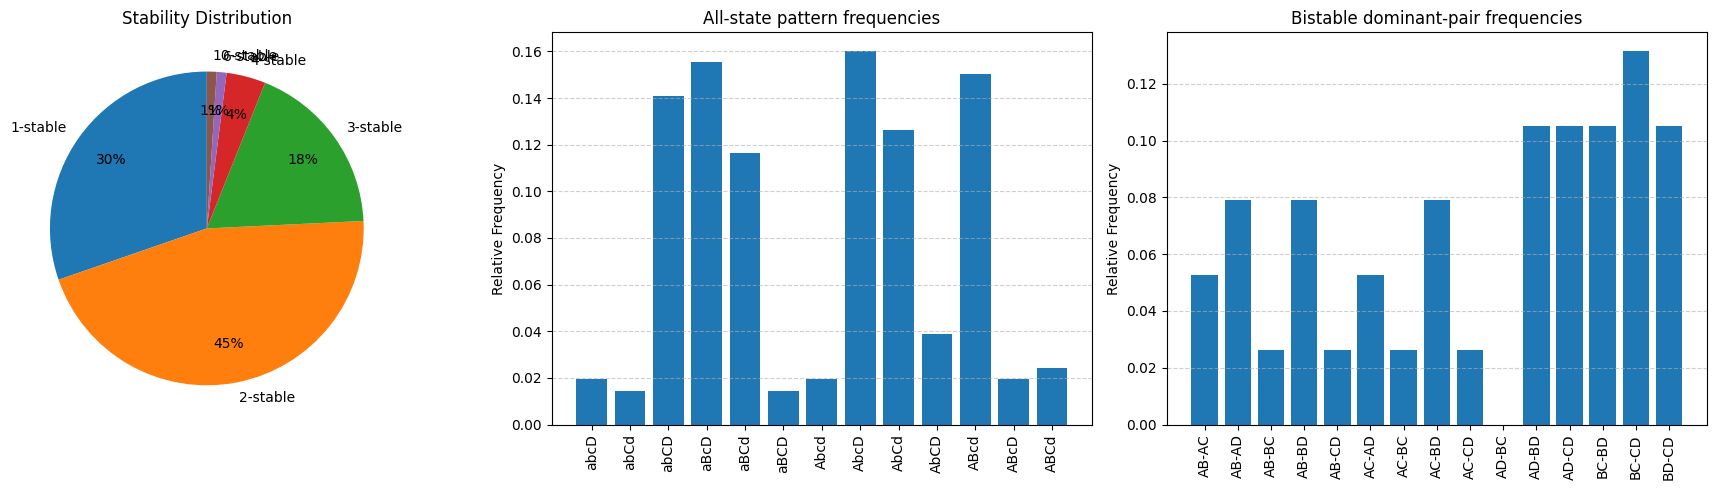

In [97]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import gaussian_kde

# ——————————————————————————————————————————————————————————————————————————————
# 1) Read & normalize your variable-length RACIPE output
# ——————————————————————————————————————————————————————————————————————————————

pt       = "/Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/initial_sims/Toggle_tetrahedron/Hypothesis_test/"
sol_file = "/Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/initial_sims/Toggle_tetrahedron/Hypothesis_test/epigenetic_BC0.5_seed101_100.tsv"
data = []
with open(sol_file) as f:
    for line in f:
        data.append([float(x) for x in line.split()])
maxlen = max(map(len, data))
for row in data:
    row.extend([np.nan]*(maxlen-len(row)))
sol = pd.DataFrame(data)

def Z_normalizing(df):
    dfn = df.copy().astype(float)
    m   = dfn.iloc[:,2:].mean(axis=0)
    s   = dfn.iloc[:,2:].std(axis=0)
    dfn.iloc[:,2:] = (dfn.iloc[:,2:] - m) / s
    return dfn

sol_z = Z_normalizing(sol)
# drop parameter sets with ≥17 steady states
sol_z = sol_z[sol_z.iloc[:,1] < 17].reset_index(drop=True)

# booleanize columns 2…end around zero
bool_sol = sol_z.copy()
bool_sol.iloc[:,2:] = (bool_sol.iloc[:,2:] > 0).astype(int)

# ——————————————————————————————————————————————————————————————————————————————
# 2) Helpers to extract bit-patterns & names
# ——————————————————————————————————————————————————————————————————————————————

def extract_row_patterns(row):
    """Return list of 4-bit strings for that row’s n steady states."""
    n    = int(row[1])
    bits = row.iloc[2:2+4*n].astype(int).tolist()
    return [''.join(str(b) for b in bits[i*4:(i+1)*4]) for i in range(n)]

def bits_to_name(bits):
    letters = ['A','B','C','D']
    return ''.join(letters[i] if bits[i]=='1' else letters[i].lower()
                   for i in range(4))

def get_dominant_genes(name):
    return ''.join(sorted(ch for ch in name if ch.isupper()))

def dominant_pair_label(s1, s2):
    d1   = get_dominant_genes(bits_to_name(s1))
    d2   = get_dominant_genes(bits_to_name(s2))
    pair = sorted([d1,d2])
    return f"{pair[0]}-{pair[1]}"

# ——————————————————————————————————————————————————————————————————————————————
# 3) Stability distribution (for pie)
# ——————————————————————————————————————————————————————————————————————————————

state_counts = sol_z.iloc[:,1].astype(int).value_counts().sort_index()
labels_pie   = [f"{n}-stable" for n in state_counts.index]
sizes_pie    = state_counts.values

# ——————————————————————————————————————————————————————————————————————————————
# 4) Master bar: all single-state patterns
# ——————————————————————————————————————————————————————————————————————————————

all_patterns = []
for _, row in bool_sol.iterrows():
    all_patterns.extend(extract_row_patterns(row))

cnt_all      = Counter(all_patterns)
patterns_all = sorted(cnt_all)
counts_all   = np.array([cnt_all[p] for p in patterns_all])
rel_all      = counts_all/counts_all.sum()
labels_all   = [bits_to_name(p) for p in patterns_all]

# ——————————————————————————————————————————————————————————————————————————————
# 5) Bistable bar: exactly 15 dominant-pair categories
# ——————————————————————————————————————————————————————————————————————————————

# six possible double-positive dominants
dp_keys       = ['AB','AC','AD','BC','BD','CD']
all_bi_labels = [f"{a}-{b}" for i,a in enumerate(dp_keys) for b in dp_keys[i+1:]]

cnt_bi = Counter()
for _, row in bool_sol.iterrows():
    if int(row[1]) == 2:
        s1, s2 = extract_row_patterns(row)
        cnt_bi[dominant_pair_label(s1, s2)] += 1

counts_bi = np.array([cnt_bi[l] for l in all_bi_labels])
total_bi  = counts_bi.sum()
rel_bi    = counts_bi/total_bi if total_bi>0 else np.zeros_like(counts_bi)

# ——————————————————————————————————————————————————————————————————————————————
# 6) Plot everything
# ——————————————————————————————————————————————————————————————————————————————

fig, axes = plt.subplots(1,3, figsize=(18,5))

# Pie
axes[0].pie(sizes_pie, labels=labels_pie, autopct='%1.0f%%',
            startangle=90, pctdistance=0.75)
axes[0].set_title("Stability Distribution")

# Master bar
axes[1].bar(labels_all, rel_all)
axes[1].set_title("All-state pattern frequencies")
axes[1].set_ylabel("Relative Frequency")
axes[1].tick_params(axis='x', rotation=90)
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

# Bistable bar
axes[2].bar(all_bi_labels, rel_bi)
axes[2].set_title("Bistable dominant-pair frequencies")
axes[2].set_ylabel("Relative Frequency")
axes[2].tick_params(axis='x', rotation=90)
axes[2].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


1
1.0    102
2.0    120
3.0     55
4.0      9
5.0      3
6.0      1
8.0      1
9.0      1
Name: count, dtype: int64
0      5.0
1      1.0
2      2.0
3      4.0
4      2.0
      ... 
287    2.0
288    1.0
289    2.0
290    2.0
291    1.0
Name: 1, Length: 292, dtype: float64


/var/folders/6q/3gs9cqgs6ll9y2vljypxl7n80000gn/T/ipykernel_46224/844771126.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pars = pd.read_csv(os.path.join(pt,"TS_parameters.dat"),


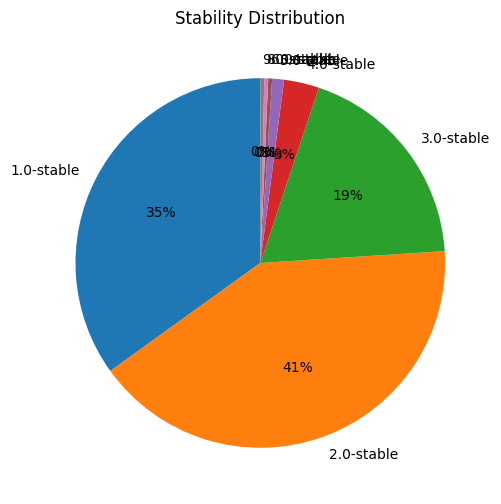

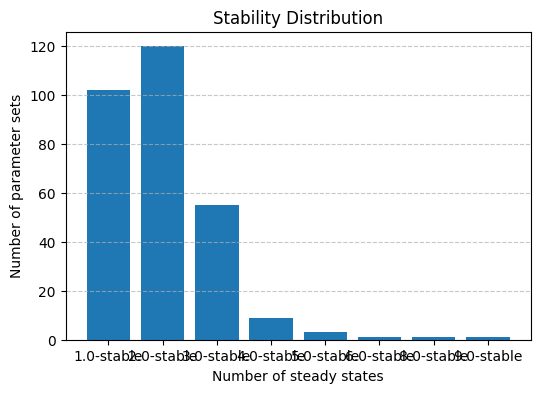

In [53]:


data = []
with open("/Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/initial_sims/Toggle_tetrahedron/Hypothesis_test/RACIPE_custom_ss_epigenetic_0.dat") as f:
    for L in f:
        data.append([float(x) for x in L.split()])
maxlen = max(len(r) for r in data)
for r in data:
    r += [np.nan]*(maxlen-len(r))
sol = pd.DataFrame(data)

# 2) read parameters + names
pars = pd.read_csv(os.path.join(pt,"TS_parameters.dat"),
                   delim_whitespace=True, header=None)
prs_names = [ln.strip() for ln in open(os.path.join(pt,"TTr.txt")) if ln.strip()]
npars = pars.shape[1]-2
prs_names = (prs_names + [f"param{i}" for i in range(1,npars+1)])[:npars]
pars.columns = ["S_no","States_number"] + prs_names

# 3) normalize, filter, booleanize
sol_z    = sol
sol_z    = sol_z[sol_z.iloc[:,1] < 17]

# 1) Frequency of each multistability
stability_counts = sol_z.iloc[:,1].value_counts().sort_index()
print(stability_counts)
print(sol_z.iloc[:,1])
# e.g. stability_counts might be:
#    1    1500
#    2     900
#    3     400
#    4     200
#    5     100
#    6      50
#    dtype: int64

# 2) Pie chart
labels = [f"{i}-stable" for i in stability_counts.index]
sizes  = stability_counts.values
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=90)
plt.title("Stability Distribution")
plt.show()

# 3) Bar chart (if you prefer)
plt.figure(figsize=(6,4))
plt.bar(labels, sizes)
plt.xlabel("Number of steady states")
plt.ylabel("Number of parameter sets")
plt.title("Stability Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


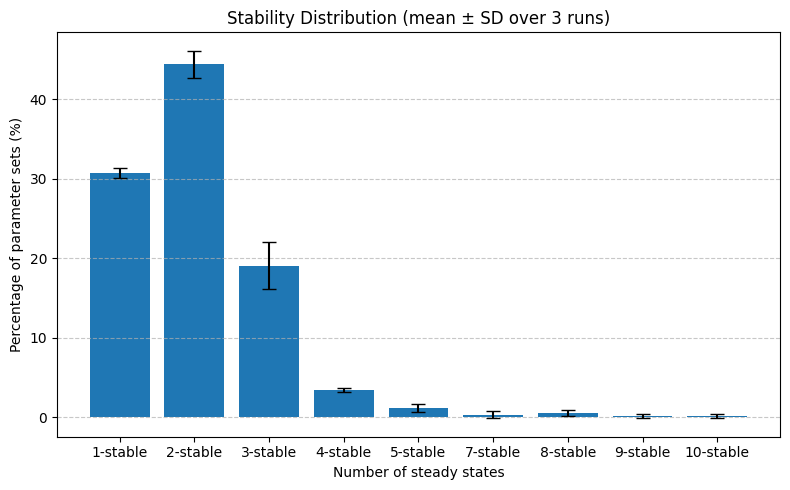

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Path to folder containing your three output files
pt = "/Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/initial_sims/Toggle_tetrahedron/Hypothesis_test"

file_names = [
    "1_random_200_RACIPE_custom_ss_noepigenetic.dat",
    "2_random_200_RACIPE_custom_ss_noepigenetic.dat",
    "3_random_200_RACIPE_custom_ss_noepigenetic.dat"
]

counts_list = []
for fname in file_names:
    # 1) load raw data
    data = []
    with open(os.path.join(pt, fname)) as f:
        for L in f:
            data.append([float(x) for x in L.split()])
    # 2) pad rows to equal length
    maxlen = max(len(r) for r in data)
    for r in data:
        r.extend([np.nan] * (maxlen - len(r)))
    sol = pd.DataFrame(data)
    # 3) filter out >17 states if needed
    sol = sol[sol.iloc[:,1] < 17]
    # 4) count stability
    stability_counts = sol.iloc[:,1].value_counts().sort_index()
    # 5) convert to percentage of sets in this run
    total = stability_counts.sum()
    counts_list.append(stability_counts / total * 100)

# 6) Align state‐numbers across runs
all_states = sorted({ int(s) for c in counts_list for s in c.index })

# 7) Build array (runs × states) of percentages
freqs = np.array([
    [c.get(state, 0.0) for state in all_states]
    for c in counts_list
])

# 8) Compute mean & std (in percentages)
means = freqs.mean(axis=0)
stds  = freqs.std(axis=0)

# 9) Plot bar with error bars (percentage)
labels = [f"{s}-stable" for s in all_states]
x = np.arange(len(all_states))

plt.figure(figsize=(8,5))
plt.bar(x, means, yerr=stds, capsize=5)
plt.xticks(x, labels)
plt.xlabel("Number of steady states")
plt.ylabel("Percentage of parameter sets (%)")
plt.title("Stability Distribution (mean ± SD over 3 runs)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [74]:
import os
import numpy as np
import pandas as pd
from itertools import combinations
from collections import Counter

# ——————————————————————————————————————————————————————————————————————————————
# Helpers
# ——————————————————————————————————————————————————————————————————————————————

def bits_to_name(bits: str) -> str:
    """Turn '1010' → 'AbCd'."""
    letters = ['A','B','C','D']
    return ''.join(letters[i] if bits[i]=='1' else letters[i].lower()
                   for i in range(4))

def get_dominant_genes(state_name: str) -> str:
    """Extract uppercase letters, sorted."""
    return ''.join(sorted(ch for ch in state_name if ch.isupper()))

def is_double_positive(binstr: str) -> bool:
    """Exactly two '1's in the 4-bit string."""
    return binstr.count('1') == 2

def make_label(bin1: str, bin2: str) -> str:
    """
    From two 4-bit strings, e.g. '1100','1010', produce 'AB-AC' (sorted).
    """
    d1 = get_dominant_genes(bits_to_name(bin1))
    d2 = get_dominant_genes(bits_to_name(bin2))
    a, b = sorted([d1, d2])
    return f"{a}-{b}"

# ——————————————————————————————————————————————————————————————————————————————
# 1) Read the RACIPE output
# ——————————————————————————————————————————————————————————————————————————————

pt        = "/Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/initial_sims/Toggle_tetrahedron/Hypothesis_test"
sol_file  = os.path.join(pt, "AB_AC_steady_states_custom.dat")

data = []
with open(sol_file) as f:
    for line in f:
        vals = [float(x) for x in line.split()]
        data.append(vals)

# pad to rectangular
maxlen = max(len(r) for r in data)
for row in data:
    row.extend([np.nan] * (maxlen - len(row)))

sol = pd.DataFrame(data)

# ——————————————————————————————————————————————————————————————————————————————
# 2) Extract the double-positive bistable rows
# ——————————————————————————————————————————————————————————————————————————————

dp_records = []
for _, row in sol.iterrows():
    param_id = int(row[0])
    n_states = int(row[1])
    if n_states != 2:
        continue

    # slice out the two 4-gene steady states
    s1 = row[   2 :   2+4].values
    s2 = row[2+4 : 2+8].values

    # binarize by zero threshold
    b1 = ''.join('1' if v>0 else '0' for v in s1)
    b2 = ''.join('1' if v>0 else '0' for v in s2)

    # keep only if both are exactly double-positive
    if is_double_positive(b1) and is_double_positive(b2):
        dp_records.append((param_id, b1, b2))

double_positive_bistable_df = pd.DataFrame(
    dp_records,
    columns=['ParameterSet','State1_Binary','State2_Binary']
)

print(f"Found {len(double_positive_bistable_df)} double-positive bistable sets.")

# ——————————————————————————————————————————————————————————————————————————————
# 3) Build all 15 possible labels
# ——————————————————————————————————————————————————————————————————————————————

# the six possible two-bit patterns
dp_bins = ['1100','1010','1001','0110','0101','0011']
dp_dom  = [get_dominant_genes(bits_to_name(b)) for b in dp_bins]

all_dp_labels = sorted(f"{a}-{b}"
                       for a,b in combinations(sorted(dp_dom),2))

# ——————————————————————————————————————————————————————————————————————————————
# 4) Assign each row its label and group
# ——————————————————————————————————————————————————————————————————————————————

# compute a new column 'Label'
double_positive_bistable_df['Label'] = double_positive_bistable_df.apply(
    lambda r: make_label(r['State1_Binary'], r['State2_Binary']),
    axis=1
)

# group parameter IDs under each label
grouped = double_positive_bistable_df.groupby('Label')['ParameterSet'].apply(list)

# ensure every of the 15 labels has an entry (even if empty)
dict_of_lists = {
    lbl: grouped.get(lbl, []).copy()
    for lbl in all_dp_labels
}

# pad to rectangular
maxlen = max(len(v) for v in dict_of_lists.values())
for lbl, lst in dict_of_lists.items():
    dict_of_lists[lbl] = lst + [np.nan]*(maxlen - len(lst))

# final wide DataFrame
df_by_label = pd.DataFrame(dict_of_lists)

# ——————————————————————————————————————————————————————————————————————————————
# Done: df_by_label has columns = the 15 labels, each column lists
# the ParameterSet IDs (and pads with NaN).
# ——————————————————————————————————————————————————————————————————————————————

print(df_by_label)


Found 92 double-positive bistable sets.
    AB-AC  AB-AD  AB-BC  AB-BD  AB-CD  AC-AD  AC-BC  AC-BD  AC-CD  AD-BC  \
0      13    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1      36    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2      98    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
3     386    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
4     591    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
87   9813    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
88   9814    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
89   9844    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
90   9871    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
91   9894    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

    AD-BD  AD-CD  BC-BD  BC-CD  BD-CD  
0     N

In [75]:
import os
import pandas as pd

# ——————————————————————————————————————————————————————————————————————————————
# 1) Paths & names
# ——————————————————————————————————————————————————————————————————————————————
pt          = "/Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/initial_sims/Toggle_tetrahedron/Hypothesis_test"
params_file = os.path.join(pt, "TS_parameters.dat")
names_file  = os.path.join(pt, "TS.prs")

# ——————————————————————————————————————————————————————————————————————————————
# 2) Load the full parameter table
# ——————————————————————————————————————————————————————————————————————————————
# read the order of kinetic names from the .prs file
with open(names_file) as f:
    lines = [ln.strip() for ln in f if ln.strip()]
param_names = [ln.split()[0] for ln in lines[1:]]

# read the params (col0=S_no, col1=Reported_states, then the kinetic columns)
pars = pd.read_csv(
    params_file,
    delim_whitespace=True,
    header=None,
    names=["S_no", "Reported_states"] + param_names
)

# ——————————————————————————————————————————————————————————————————————————————
# 3) Pick out the IDs under "AB-AC" in your grouped DataFrame
#    (df_by_label must already exist in your namespace)
# ——————————————————————————————————————————————————————————————————————————————
# drop any NaNs and convert to int
ab_ac_ids = df_by_label["AB-AC"].dropna().astype(int).tolist()

# filter the parameters table
ab_ac_params = pars[pars["S_no"].isin(ab_ac_ids)].copy()

# ——————————————————————————————————————————————————————————————————————————————
# 4) Write to CSV
# ——————————————————————————————————————————————————————————————————————————————
out_file = os.path.join(pt, "AB-AC_TS_parameters.tsv")
ab_ac_params.to_csv(out_file, sep='\t', index=False)

print(f"Wrote {len(ab_ac_params)} parameter sets to {out_file}")


Wrote 92 parameter sets to /Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/initial_sims/Toggle_tetrahedron/Hypothesis_test/AB-AC_TS_parameters.tsv


/var/folders/6q/3gs9cqgs6ll9y2vljypxl7n80000gn/T/ipykernel_46224/976994983.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pars = pd.read_csv(


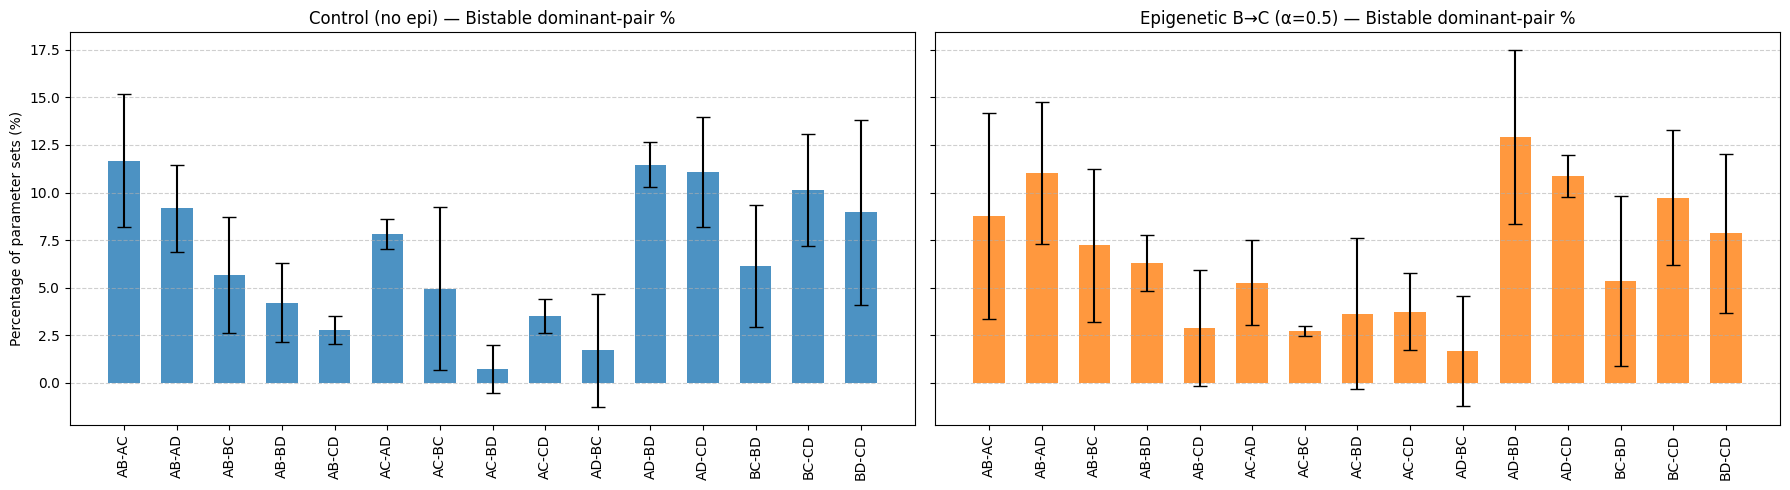

In [90]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# ────────────────────────────────────────────────────────────────────────────────
# 1) Helpers to load & preprocess one RACIPE output file
# ────────────────────────────────────────────────────────────────────────────────
def load_and_booleanize(sol_file):
    # load into ragged array
    data = []
    with open(sol_file) as f:
        for line in f:
            toks = line.strip().split()
            # skip empty or non‐numeric header lines
            if not toks or not toks[0].replace('.','',1).isdigit():
                continue
            try:
                row = [float(x) for x in toks]
            except ValueError:
                continue
            data.append(row)
    maxlen = max(map(len, data))
    for row in data:
        row.extend([np.nan] * (maxlen - len(row)))
    sol = pd.DataFrame(data)

    # z-score normalize columns 2…end
    dfn = sol.copy().astype(float)
    m   = dfn.iloc[:,2:].mean(axis=0)
    s   = dfn.iloc[:,2:].std(axis=0)
    dfn.iloc[:,2:] = (dfn.iloc[:,2:] - m) / s

    # drop any with ≥17 steady-states
    sol_z = dfn[dfn.iloc[:,1] < 17].reset_index(drop=True)

    # booleanize around zero
    bool_sol = sol_z.copy()
    bool_sol.iloc[:,2:] = (bool_sol.iloc[:,2:] > 0).astype(int)
    return bool_sol

# ────────────────────────────────────────────────────────────────────────────────
# 2) Extract bistable dominant-pair relative freqs for one booleanized DataFrame
# ────────────────────────────────────────────────────────────────────────────────
def extract_row_patterns(row):
    n    = int(row[1])
    bits = row.iloc[2:2+4*n].astype(int).tolist()
    return [''.join(str(b) for b in bits[i*4:(i+1)*4]) for i in range(n)]

letters = ['A','B','C','D']
def bits_to_name(bits):
    return ''.join(letters[i] if bits[i]=='1' else letters[i].lower()
                   for i in range(4))

def get_dominant_genes(name):
    return ''.join(sorted(ch for ch in name if ch.isupper()))

def dominant_pair_label(s1, s2):
    d1 = get_dominant_genes(bits_to_name(s1))
    d2 = get_dominant_genes(bits_to_name(s2))
    a, b = sorted([d1, d2])
    return f"{a}-{b}"

# the 15 possible labels (all unordered pairs of the 6 double-positive keys)
dp_keys       = ['AB','AC','AD','BC','BD','CD']
all_bi_labels = [f"{a}-{b}"
                 for i,a in enumerate(dp_keys)
                 for b in dp_keys[i+1:]]  # yields 15

def compute_rel_bi(sol_file):
    bs = load_and_booleanize(sol_file)
    cnt = Counter()
    for _, row in bs.iterrows():
        if int(row[1]) == 2:
            s1, s2 = extract_row_patterns(row)
            cnt[dominant_pair_label(s1, s2)] += 1

    counts = np.array([cnt[l] for l in all_bi_labels], float)
    total  = counts.sum()
    return counts/total if total>0 else np.zeros_like(counts)

# ────────────────────────────────────────────────────────────────────────────────
# 3) Point these at your six files
# ────────────────────────────────────────────────────────────────────────────────
pt = "/Users/hiteshkandarpa/Desktop/IISC/Summer'25/Code/initial_sims/Toggle_tetrahedron/Hypothesis_test/"

control_files = [
    os.path.join(pt, f"control_seed{i}_100.tsv")
    for i in (101,42,2025)
]
epi_files = [
    os.path.join(pt, f"epigenetic_BC0.5_seed{i}_100.tsv")
    for i in (101,42,2025)
]

# ────────────────────────────────────────────────────────────────────────────────
# 4) Compute replicate matrices (3×15)
# ────────────────────────────────────────────────────────────────────────────────
ctrl_mat = np.vstack([compute_rel_bi(f) for f in control_files])
epi_mat  = np.vstack([compute_rel_bi(f) for f in epi_files])

ctrl_mean = ctrl_mat.mean(axis=0)
ctrl_std  = ctrl_mat.std(axis=0, ddof=1)
epi_mean  = epi_mat.mean(axis=0)
epi_std   = epi_mat.std(axis=0, ddof=1)

# ────────────────────────────────────────────────────────────────────────────────
# 5) Plot the two bar-plots side by side
# ────────────────────────────────────────────────────────────────────────────────
x     = np.arange(len(all_bi_labels))
width = 0.6

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,5), sharey=True)

ax1.bar(x, ctrl_mean*100, width,
        yerr=ctrl_std*100, capsize=5, color='C0', alpha=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(all_bi_labels, rotation=90)
ax1.set_title("Control (no epi) — Bistable dominant-pair %")
ax1.set_ylabel("Percentage of parameter sets (%)")
ax1.grid(axis='y', linestyle='--', alpha=0.6)

ax2.bar(x, epi_mean*100, width,
        yerr=epi_std*100, capsize=5, color='C1', alpha=0.8)
ax2.set_xticks(x)
ax2.set_xticklabels(all_bi_labels, rotation=90)
ax2.set_title("Epigenetic B→C (α=0.5) — Bistable dominant-pair %")
ax2.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
